<h1>Predicting Customer Purchase Frequency</h1>


<h2><span style='background:#CAFFBF'>Introduction:</span></h2>

<div style="text-align: justify">
Understanding customer behavior, particularly consumer purchase frequency, is crucial for businesses aiming to achieve success in competitive markets. Purchase frequency refers to the number of times a customer makes a purchase within a specific time period, such as a week, month, or year. By exploring the factors that influence purchase frequency among different customer demographics, companies can gain valuable insights to shape their marketing strategies effectively and potentially enhance overall profitability. Specifically focusing on the variables of age, income and spending, this project aims to determine which of these variables from the dataset will have an effect on customer purchase frequency.        

<br>In a 2003 survey study assessing customers' clothing spending habits, customers' responses were divided into three groups of clothing purchase frequencies. The result showed a positive relationship between age and purchase frequency (Lennon et al. 2003). For this reason, we have chosen to assess age as a predictive variable in our classification model. 

A study conducted by Kholis & Ma’rifa (2021) concluded that income is one of the main factors affecting consumer purchase frequency, with higher incomes correlated to higher purchase frequency. This supports the idea that one's income strongly influences the extent to which people will spend their money on items they need or want. As such, we have included income as a potential predictor variable for our classification model. 

As expected, there appears to be a consistent positive relationship between spending and purchase frequency, with higher purchase frequencies linked to higher annual spending. Due to this positive relationship, we will include spending as a third predictor variable in our model. 

To address our research question, we will utilize the Customer Spending Dataset obtained from Kaggle (can be found using the link provided). This dataset includes the variables age, gender, education level, income, country of residence, purchase frequency, and spending amounts, although we will only include age, income, spending and purchase frequency for our model. Purchase frequency is quantified as the number of purchases made by a customer within a specified time period, ranging from 0.1 (least often) to 1.0 (most often). 

The dataset consists of an equal proportion of male and female customers ages 18 to 65, with incomes ranging from 20,000 to 99,800 dollars. We will narrow down the dataset to use age, income and spending as the predictors for consumers' purchase frequency. By analyzing the relationships between age, income, spending and purchase frequency, we aim to identify the significant predictors of purchase frequency and provide valuable insights for businesses seeking to optimize their marketing strategies.


 
> Dataset Link: https://www.kaggle.com/datasets/goyaladi/customer-spending-dataset 


<h2><span style='background:#9BF6FF'>Methods & Results:</span></h2>

The methodology implemented in our project is as follows:
<br>
1. Load the dataset from Kaggle. 
2. Clean the data.
3. Wrangle the data into a format suitable for analysis.
4. Create the Training and Testing data sets.
5. Understand the Training data set using summary statistics and visualizations of variable distributions. 
6. Develop and fine tune a knn-classification model. 
7. Test the model's accuracy. 
8. Create visualizations of the analysis.  

We document our code at each step to clearly explain our process and ensure our analysis is replicable. 

In [47]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(broom)
library(ggplot2)
library(dplyr)
set.seed(3456)
options(repr.plot.width = 10, repr.plot.height = 5)

In [48]:
# STEP 1: Read data into project via url. 
data <- read_csv("https://raw.githubusercontent.com/Kaylan-W/Dsci_project/main/data/customer_data.csv")

# STEP 2: The data will be cleaned by removing unused columns and handling NA values. 
data_downsized<- data %>%
        select(-name, -country, -gender, -education) %>%
        na.omit()

# STEP 3: The data will be wrangled by creating a categorical variable from the column purchase_frequency.
# The existing range of values for purchase_frequency were split into 4 numerical sub categories then given the 
# labels Very Low, Low, High and Very High.
breakpoints <- c(0, 0.25, 0.5, 0.75, 1)
labels <- c("Very Low", "Low", "High", "Very High")
tidydata<- data_downsized %>% mutate(pf_categories = cut(data_downsized$purchase_frequency, 
                                                    breakpoints, labels = labels, include.lowest = TRUE)) 

# STEP 4: Split data into training and testing data sets. 75% of the data will be put into the training set.
data_split <- initial_split(tidydata, prop = 0.75, strata = pf_categories)  
train_split <- training(data_split)   
test_split <- testing(data_split)

# STEP 5.1: Create Summary Table for the training set.
summary_table <- train_split %>%
  group_by(pf_categories) %>%
  summarize(count = n(),
            age_mean = mean(age),
            age_sd = sd(age),
            income_mean = mean(income),
            income_sd = sd(income),
            spending_mean = mean(spending),
            spending_sd = sd(spending)) %>%
  arrange(desc(count))

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): name, gender, education, country
dbl (4): age, income, purchase_frequency, spending

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Table 1: Head of the Training Data Set  

In [49]:
head(train_split)

age,income,purchase_frequency,spending,pf_categories
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
49,82468,0.6,12674.040,High
34,32225,0.7,6727.875,High
19,48896,0.6,5666.880,High
56,31997,0.6,12959.910,High
48,66812,0.7,14238.420,High
32,94468,0.7,15906.380,High


#### Table 2: Summary Statistics for the Training Data Set  

In [50]:
summary_table

pf_categories,count,age_mean,age_sd,income_mean,income_sd,spending_mean,spending_sd
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Low,221,40.84615,13.68389,56969.54,22453.04,6957.559,2334.900
Very High,216,41.44907,13.83515,59923.15,24005.60,15345.161,3699.308
High,171,42.51462,13.55657,58869.29,23301.60,11257.531,2737.969
Very Low,141,40.64539,14.39749,60063.39,24019.84,2432.809,1021.301


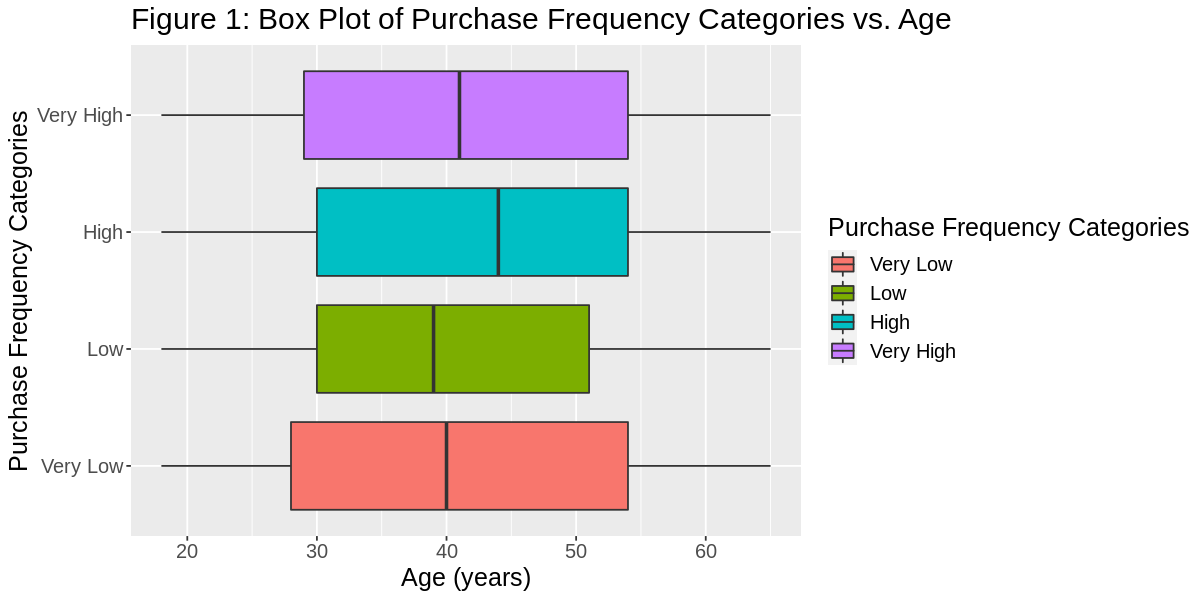

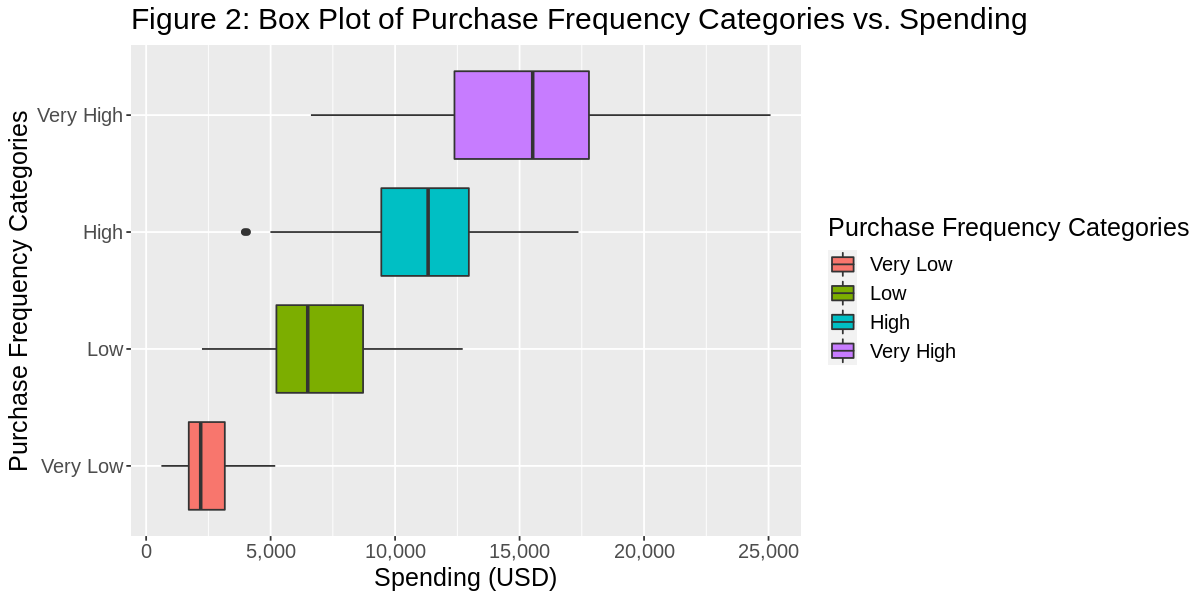

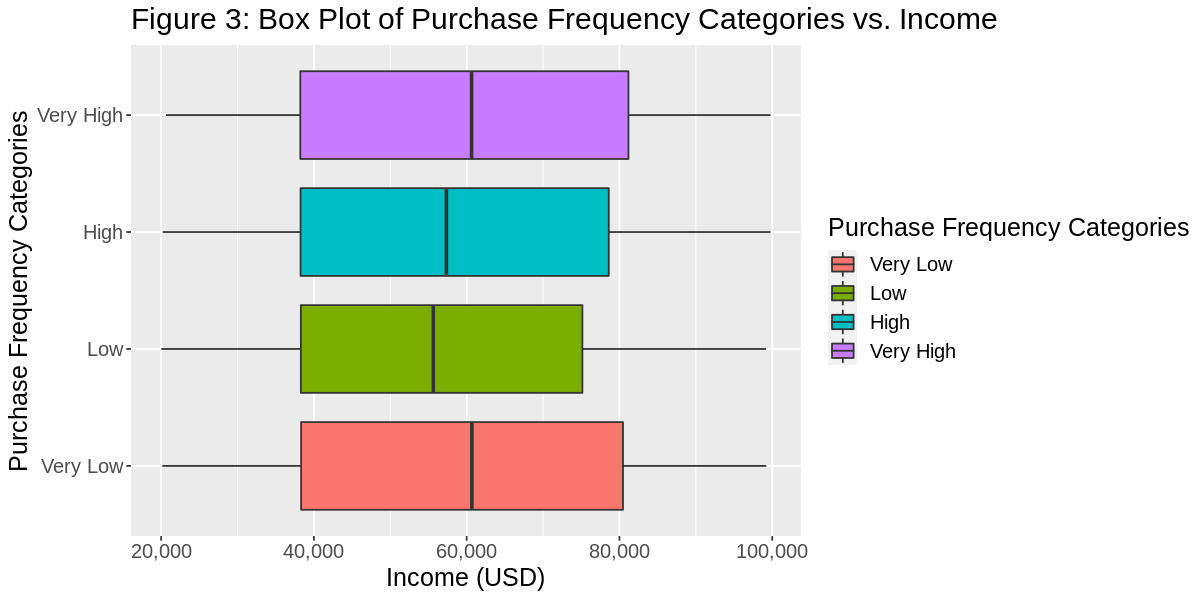

In [51]:
# STEP 5.2: Create visualizations of the distribution of the variables age, spending, and income within the training set.
age_plot<- ggplot(train_split, aes(x = age, y = pf_categories, fill = pf_categories)) +
  geom_boxplot() +
  labs(x = 'Age (years)', y = 'Purchase Frequency Categories', fill = 'Purchase Frequency Categories',
       title = 'Figure 1: Box Plot of Purchase Frequency Categories vs. Age') +
  theme(text = element_text(size = 15))
age_plot

spending_plot<- ggplot(train_split, aes(x = spending, y = pf_categories, fill = pf_categories)) +
  geom_boxplot() +
  labs(x = 'Spending (USD)', y = 'Purchase Frequency Categories', fill = 'Purchase Frequency Categories',
       title = 'Figure 2: Box Plot of Purchase Frequency Categories vs. Spending') +
  theme(text = element_text(size = 15)) +
  scale_x_continuous(labels = scales::comma)
spending_plot

income_plot<- ggplot(train_split, aes(x = income, y = pf_categories, fill = pf_categories)) +
  geom_boxplot() +
  labs(x = 'Income (USD)', y = 'Purchase Frequency Categories', fill = 'Purchase Frequency Categories',
       title = 'Figure 3: Box Plot of Purchase Frequency Categories vs. Income') +
  theme(text = element_text(size = 15)) +
  scale_x_continuous(labels = scales::comma)
income_plot

We created box plots for each potential predictor variable (income, spending, age) to compare with the summary table above and determine which to use in our classfication models. Visualizing the distribution of each variable within the purchase frequency categories will allow us to see which variables have an effect. 
The above three boxplots indicate that both spending and age have an impact on consumer spending frequency, while income does not show a significant effect.

According to the summary table mean and the box plot median, individuals in the high spending category tend to be slightly older, with an average age of 53 years, compared to the low, very low, and very high spending categories, where the average age is around 50 years. The age distribution across these categories is quite similar, with a standard deviation of approximately 13 years.

There is a strong positive correlation observed between spending and purchase frequency. Individuals who spend less tend to purchase less frequently, while those who spend more tend to purchase more frequently. The means of the spending categories, as shown in the summary table, exhibit greater variability compared to the age variable, ranging from 2516 to 15531 dollars annually. Similarly, the median values in the box plots also vary significantly, ranging from around 2,400 to 15,500 dollars. Additionally, there is more variation within each spending category, as indicated by the standard deviation. The Very Low spending category has the lowest standard deviation of 1,018 dollars, whereas the Very High spending category has the highest standard deviation of 3,706 dollars.

The income box plot reveals the least significant findings. The means in the summary table for the income categories all fall within the range of 58,000 to 60,000 dollars per year, and the medians in the box plot are slightly below or slightly above 60,000 dollars per year. The variation within the income categories is also not substantial, with standard deviation values ranging between 22,500 and 24,000 dollars.



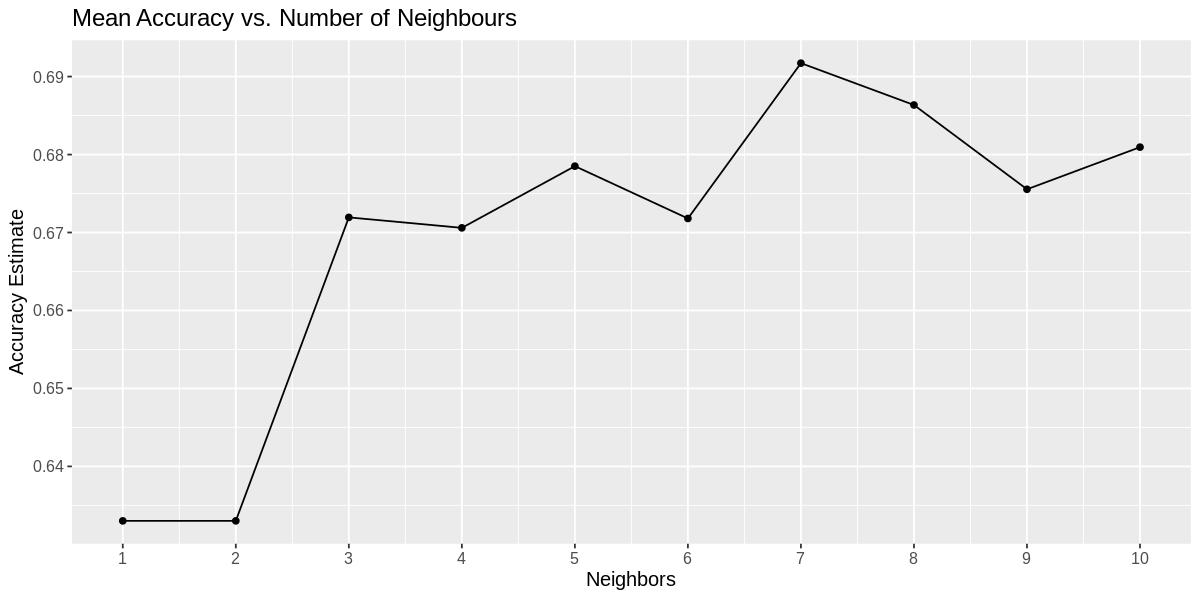

In [69]:
# STEP 6.1: Create a recipe that centres and scales all predictors.
purchase_recipe <- recipe(pf_categories ~ age + spending + income, data = train_split) |> 
            step_scale(all_predictors()) |>
            step_center(all_predictors())

# STEP 6.2: Create a knn specification.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
            set_engine("kknn") |> 
            set_mode("classification")

# STEP 6.3: Implement 5-fold cross validation, varying the number of neigbours from 1 to 10.
k_vals <- tibble(neighbors = 1:20)
purchase_vfold <- vfold_cv(train_split, v = 5, strata = pf_categories)

# STEP 6.4: Compare the estimated accuracy of all computed models to determine the best value for k.
knn_workflow <- workflow() |>
  add_recipe(purchase_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = purchase_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Mean Accuracy vs. Number of Neighbours") + 
  scale_x_continuous(breaks = seq(0, 10, by = 1)) +  # adjusting the x-axis
  scale_y_continuous(breaks = seq(0, 1.5, by = 0.01)) + # adjusting the y-axis
  theme(text = element_text(size = 12))
accuracy_vs_k 

According to the graph of Mean Accuracy vs. Number of Neighbours, the best value to use for k (between 1 and 20) is 14. This is the k value that will be used in our final model. 

In [90]:
# STEP 6.5: Create another model with the best parameters. 
kkn_spec2<-nearest_neighbor(weight_func = "rectangular", neighbors= 14) |>
       set_engine("kknn") |>
       set_mode("classification")

knn_workflow2 <- workflow() %>%
  add_recipe(purchase_recipe) %>%
  add_model(kkn_spec2) %>%
  fit(data = train_split)

# STEP 7: Use the model on the test data and assess its accuracy. 
purchase_predict <- knn_workflow2 |>
        predict(test_split) |>
        bind_cols(test_split) 

purchase_metrics <- purchase_predict |>
        metrics(truth = pf_categories, estimate = .pred_class)|>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        pull()
cat("Model Accuracy on Testing Set:", purchase_metrics)

purchase_conf_mat <- purchase_predict |> 
      conf_mat(truth = pf_categories, estimate = .pred_class)

Model Accuracy on Testing Set: 0.7171315

#### Table 3: Confusion Matrix for the Final Model when Run on the Testing Set  

In [88]:
purchase_conf_mat

           Truth
Prediction  Very Low Low High Very High
  Very Low        43   6    0         0
  Low              4  58   13         2
  High             0   9   21        13
  Very High        0   1   23        58

In [ ]:
# STEP 8: Create a visualization of the results 

<h2><span style='background:#BDB2FF'>Discussion:</span></h2>

<span style='color:#FE81BF'>
1. summarize what you found
<br>2. discuss whether this is what you expected to find.
<br>4. discuss what impact could such findings have.
<br>5. discuss what future questions could this lead to. </span>



* We expect to find that people with higher income and age have a higher purchase frequency. 
* We also expect to find gender will not have an impact on purchase frequency.
* These findings could impact how stores will go about marketing their products to people of different economic class' and demographics. The outcome of this data analysis could provide information on which customers a company should advertise towards. 
* Further questions could be asked to analyze which products these individuals with different demographical characteristcs (ex. higher income) prefer and how the advertising affects their purchase frequency.

<h2><span style='background:#FFC6FF'>References:</span></h2>

Kholis, N., &amp; Ma’rifa, A. (2021, November 19). The influence of price and income on purchase decisions among fast-food consumers: The mediating effect of lifestyle. https://www.unisza.edu.my/icbm2021/images/PROGRAM_BOOK/PAPER_12.pdf 

Lennon, S. J., Sanik, M. M., &amp; Stanforth, N. F. (2003). Motivations for television shopping: Clothing purchase frequency and personal characteristics. Clothing and Textiles Research Journal, 21(2), 63–74. https://doi.org/10.1177/0887302x0302100202 


